Make sure to set all parameters in this top cell. Included in the repository are the Biagi, Puech, and BSR databases. All have a minimum indexing eV of 0.001. Biagi has a maximum indexing eV of 950, BSR has a maximum indexing eV of 300, and Puech has a maximum indexing eV of 150.

In [1]:
import numpy as np
import scipy.interpolate as interpolate
import math
import re
import glob
from matplotlib import pyplot as plt
import os
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D

database = 'BSR' # Will use the cross-sections contained in cross-sections/{database}
eV_min = 1.36e-3      # The minimum eV addressable using this dataset
eV_max = 2.00e2     # The maximum eV addressable using this dataset
eV_steps = 1000    # The number of steps to break each cross-section LUT into
angle_min = 0.0
angle_max = 180.0
angle_steps = 180

In [2]:
m_e = 9.1e-31

def E_to_v(eV):
    return np.sqrt((2 * eV * 1.60218e-19) / (m_e))

# Low eV energy-independent LAr cross-sections that merge with the (single) momentum-transfer GAr cross-section at several eV (see Wojcik and Tachiya)
def liquid_sigma_e(eV, gas_sigma_p):
    if eV < 3.85:
        return 5.5e-16
    return gas_sigma_p(eV)

def liquid_sigma_p(eV, S, gas_sigma_p):
    if eV < 4.6:
        return S(eV) * 5.5e-16
    return gas_sigma_p(eV)

eV_list = np.logspace(np.log10(eV_min), np.log10(eV_max), eV_steps)
angle_list = np.linspace(angle_min, angle_max, angle_steps)

# 1D momentum-transfer XSEC

In [3]:
sigma_eVs_1D, sigma_1D = np.loadtxt(f'cross-sections/BSR/momentum_xsec.txt', unpack=True)  # m^2
sigma_1D *= 1e4                                                                                  # to cm^2
sigma_func_1D = interpolate.interp1d(sigma_eVs_1D, sigma_1D, kind='slinear', fill_value=(0., 0.), bounds_error=False)

# Subset where the energy is greater than 10 eV
sub_indices = np.where(sigma_eVs_1D > 11.65)
sigma_eVs_1D_sub = np.array( [sigma_eVs_1D[n] for n in sub_indices[0]] )
sigma_1D_sub = np.array( [sigma_1D[n] for n in sub_indices[0]] )

# Elastic differential cross sections

In [4]:
sigma_p_angle,sigma_p_eVs, sigma_p = np.loadtxt(f'diff-cross-sections/{database}/Elastic.txt', unpack=True) # m^2
reduced_list = sigma_p_eVs[::181]
sigma_p *= 1e4 # to cm^2/sr
#Integrate out the /sr to cm^2
angle = 0.0
for i in np.arange(len(sigma_p)):
    angle_rad = (math.pi/180.0)*angle
    angle_1 = angle-1
    cost = 2 * math.pi * (math.cos(angle_1)-math.cos(angle))
    #cost = (1.0 - math.cos(angle_rad))*(1.0/4.0*math.pi)
    #if(angle > 0):
    #    cost = 2.0*math.pi*(0.25*(-math.cos((angle_1*math.pi)/90.0) - 4.0*math.cos((angle*math.pi)/180.0) + math.cos((angle*math.pi)/90.0)) + math.cos((angle_1*math.pi)/180.0))
    sigma_p[i] *= cost
    angle += 1
    if(angle == 181.0):
        angle = 0.0
sigma_p_func = np.add.reduceat(sigma_p, np.arange(0,len(sigma_p),181))

# Prepare input for .h File

In [5]:
angle_lists = np.arange(181)
#print(len(angle_lists))
#print(angle_lists)
counter = 0
entry = np.full((len(reduced_list)+len(sigma_eVs_1D_sub), angle_steps+3),0.)
#print(entry)
for i in np.arange(len(reduced_list)):
    for j in np.arange(angle_steps+3):
        if(j == 0):
            entry[i,j] = reduced_list[i]
        elif(j == 1):
            entry[i,j] = sigma_p_func[i]
        else:
            entry[i,j] = sigma_p[counter]/sigma_p_func[i] 
            counter += 1
            
#'''
# last differential xsec (ratios only)
N = len(reduced_list)
last_diff_xsec = entry[N-1]
#print ('last diff. vector : ',last_diff_xsec)
#print ('added after element %i'%N)
# add xsecs beyond 11.65 eV from 1D distributions
for i in range(len(sigma_eVs_1D_sub)):
    energy = sigma_eVs_1D_sub[i]
    xsec   = sigma_1D_sub[i]
    for j in np.arange(angle_steps+3):
        if (j == 0):
            entry[N+i,j] = energy
        elif (j == 1):
            entry[N+i,j] = xsec
        else:
            entry[N+i,j] = last_diff_xsec[j]
#'''

# inelastic differential cross sections

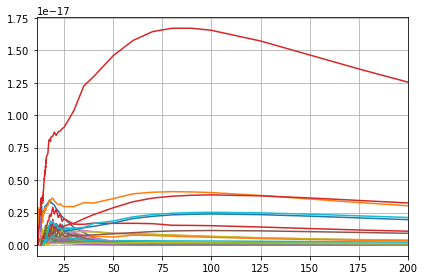

In [6]:
sigma_inel_angle, sigma_inel_eVs, sigma_inel = np.loadtxt(f'diff-cross-sections/{database}/inelastic_0.txt', unpack=True)
sigma_inel *= 1e4
reduced_inel = sigma_inel_eVs[::181]

sigma_inel_func = np.add.reduceat(sigma_inel, np.arange(0,len(sigma_inel), 181))

file_list = []
avgs = np.full(3, 0.)
#Inelastic differential cross sections
level = [11,13,14]
for ex_level in [11, 13, 14]:
#for ex_level in [11]:
    file_list.append(glob.glob(f'diff-cross-sections/{database}/inelastic_{ex_level}*.txt'))

#sigma_ex = np.full((3, eV_steps, angle_steps+angle_steps), 0.)
#print(sigma_ex)
np.seterr('raise')
sigma_ex_int = np.full((3, eV_steps),0.)
sigma_ex_int_tot = np.zeros(eV_steps)
sigma_ex_tot = np.zeros((eV_steps,angle_steps))
angle_size = np.arange(len(angle_list))
eV_size = np.arange(len(eV_list))
eV_int = 0.0
#print(file_list)
sigma_level = []
energy_vals = []
sigma_func = []
total_eVs = []
for i in np.arange(3):
#for i in np.arange(1):
    file_list[i].sort()
#print(file_list)
for k, file_group in enumerate(file_list):
    file_num = 0
    reduced_eVs = [0]*len(file_group)
    sigma_sum = []
    #print(reduced_eVs)
    for file in file_group:
        num_files = len(file_group)
        x_temp, y_temp, z_temp = np.loadtxt(file, unpack=True)
        z_temp *= 1e4
        energy = float(re.search(r'\d*\.\d*', file)[0])
        angle = 0
        for i in np.arange(len(z_temp)):
            angle_rad = (math.pi/180.0)*angle
            angle_1 = angle-1
            momt = (energy)/y_temp[i]
            cost = -math.pi*(math.cos(0) - math.cos((math.pi)/180.0))*(momt*math.cos(0) + momt*math.cos((math.pi)/180.0) - 2.0)
            if(angle > 0):
                cost = -math.pi*(math.cos((angle_1*math.pi)/180.0) - math.cos((angle*math.pi)/180.0))*(momt*math.cos((angle_1*math.pi)/180.0) + momt*math.cos((angle*math.pi)/180.0) - 2.0)
                #if(y_temp[i] == 100):
                    #print(cost)
                #cost = 2.0*math.pi*(0.25*(-math.cos((angle_1*math.pi)/90.0) - 4.0*math.cos((angle*math.pi)/180.0) + math.cos((angle*math.pi)/90.0)) + math.cos((angle_1*math.pi)/180.0))
            z_temp[i] *= cost
            #if(y_temp[i] == 100):
                #print(angle)
                #print(z_temp[i])
            angle += 1
            if(angle == 181.0):
                angle = 0.0
        reduced_eVs[file_num] = y_temp[::181]
        #reduced_inel = np.delete(reduced_inel,0)
        #print(reduced_eVs)
        sum_xsec = np.add.reduceat(z_temp, np.arange(0,len(z_temp), 181))
        #sum_xsec *= 1.0/(4.0*math.pi)
        if(file_num==0):
            min_e = y_temp[0]
            sigma_ex = [0]*num_files
            total_e_values = reduced_eVs[file_num]
            energy_vals.append(reduced_eVs[file_num])
            num_files_with_e = np.full(len(total_e_values),0.0)
            #print(len(reduced_eVs[file_num]))
            #print(len(total_e_values))
            total_eVs.append(total_e_values)
            #print(total_e_values)
        #sigma_ex[file_num] = np.full((len(reduced_eVs[file_num]), angle_steps+3),0.)
        sigma_ex[file_num] = np.full((len(reduced_eVs[0]), angle_steps+3),0.)
        #print(sigma_ex[0][0,0])
        #sigma_inel_func = np.delete(sigma_inel_func,len(sigma_inel_func)-1)
        #print(sum_xsec)
        #angle_lists = np.arange(181)
        #print(len(angle_lists))
        #print(angle_lists)
        counter = 0
        #print(len(sigma_ex))
        sigma_plot = np.full(len(reduced_eVs[0]), 0.0)
        #for i in np.arange(len(reduced_eVs[file_num])):
        energy_skip = 0
        for i in np.arange(len(reduced_eVs[0])):
            if(reduced_eVs[0][i] not in reduced_eVs[file_num]):
                sigma_ex[file_num][i,0] = reduced_eVs[0][i]
                sigma_plot[i] = 0.0
                energy_skip += 1
                continue
            for j in np.arange(angle_steps+3):
                if(j == 0):
                    #sigma_ex[file_num][i,j] = reduced_eVs[file_num][i]
                    sigma_ex[file_num][i,j] = reduced_eVs[0][i]
                elif(j == 1):
                    #sigma_ex[file_num][i,j] = sum_xsec[i]
                    sigma_ex[file_num][i,j] = sum_xsec[i-energy_skip]
                    #sigma_plot[i] = sum_xsec[i]
                    sigma_plot[i] = sum_xsec[i-energy_skip]
                else:
                    #sigma_ex[file_num][i,j] = z_temp[counter]/sum_xsec[i] 
                    sigma_ex[file_num][i,j] = z_temp[counter]/sum_xsec[i-energy_skip]
                    counter += 1
        sigma_sum.append(np.zeros(len(reduced_eVs[0])))
        #print(sigma_sum)
        for n in np.arange(len(total_e_values)):
            e_val = total_e_values[n]
            if(e_val in sigma_ex[file_num]):
                sigma_sum[0][n] += sigma_plot[n]
                if(sigma_plot[n] > 0.0):
                    num_files_with_e[n] += 1

        plt.plot(reduced_eVs[0], sigma_plot, label=energy)

        file_num += 1
        avgs[k] += float(re.search(r'\d*\.\d*', file)[0])

    for num in np.arange(1,num_files):
        #for val in np.arange(len(reduced_eVs[num])):
        for val in np.arange(len(reduced_eVs[0])):
            e_val = reduced_eVs[0][val]
            if(e_val in sigma_ex[num]):
                #for i in np.arange(len(reduced_eVs[num])):
                for j in np.arange(angle_steps+3):
                    if(j == 1):
                        sigma_ex[0][val,j] += sigma_ex[num][val,j]
                    if(j >= 2):
                        sigma_ex[0][val,j] += sigma_ex[num][val,j]
                #sigma_sum[0][val] += sigma_sum[num][val]
    #print(reduced_eVs[0])
    for val in np.arange(len(total_e_values)):
        for j in np.arange(angle_steps+3):
            if(j >= 2):
                sigma_ex[0][val][j] /= num_files_with_e[val]
    #for i in np.arange(len(reduced_eVs[0])):
        #print(sum(sigma_ex[0][i]) - reduced_eVs[0][i] - sigma_ex[0][i,1])
    sigma_func.append(np.zeros(len(reduced_eVs[0])))
    for val in np.arange(len(total_e_values)):
        #sigma_func[k][val] = sigma_ex[0][val,1]
        sigma_func[k][val] = sigma_sum[0][val]
    
    sigma_level.append(sigma_ex[0])

eV_min = 11.00
eV_max = 200.00
plt.xlim(eV_min, eV_max)
#plt.xscale('log')
#plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


The below cell condenses the given excitation cross-sections into four energy bands.

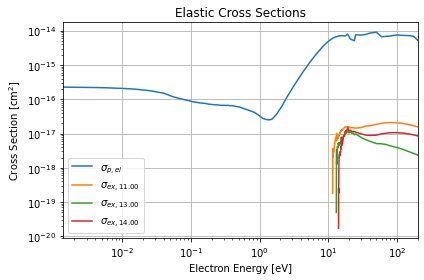

In [7]:
plt.plot(reduced_list, sigma_p_func, label=r'$\sigma_{p,el}$')
#plt.plot(reduced_inel, sigma_inel_func, label=r'$\sigma_{p,inel}$')
for k in np.arange(len(sigma_func)):
    plt.plot(total_eVs[k], sigma_func[k], label=f'$\sigma_{{ex,{level[k]:.2f}}}$')

#plt.plot(eV_list, sigma_ex_int_tot, 'g', label='$\sigma_{ex,tot}$')
eV_min = min(reduced_list)
eV_max = max(reduced_list)
plt.xlim(eV_min, eV_max)

plt.xlabel('Electron Energy [eV]')
plt.ylabel('Cross Section [cm$^2$]')

#plt.title('Excitation Cross Sections')
plt.title('Elastic Cross Sections')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The cell below show all cross-sections together.

In [ ]:
plt.plot(reduced_list, sigma_p_func, label=r'$\sigma_p$')
#plt.plot(eV_list, final_sigma_e(eV_list), label=r'LAr $\sigma_E$')
#plt.plot(eV_list, final_sigma_p(eV_list), label=r'LAr $\sigma_p$')

#plt.plot(eV_list, sigma_i_func(eV_list), label=r'$\sigma_I$')

#for k, ex_level in enumerate(sigma_ex):
#    plt.plot(eV_list, ex_level, label=f'$\sigma_{{ex,{avgs[k]:.2f}}}$')

plt.xlabel('Energy [eV]')
plt.ylabel(r'Cross-Section [cm$^2$]')

plt.title('Ar Elastic Scattering Cross-Section')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The below cell calculates and shows each cross-section multiplied by the electron velocity corresponding to the $x$-axis kinetic energy. These values are used to calculate the probability of scattering events. $K_\mathrm{max}$ is taken to be the peak of the sum of these values.

In [ ]:
#compos_x_sec = np.array([])
#for i, e in enumerate(eV_list):
#    compos_x_sec = np.append(compos_x_sec, max(final_sigma_e(e), final_sigma_p(e) + sigma_ex_tot[i]))

#plt.plot(eV_list, sigma_p_func(eV_list) * E_to_v(eV_list) * 1e2, label=r'GAr $v\sigma_p$')
#plt.plot(eV_list, (sigma_p_func(eV_list) + sigma_ex_tot) * E_to_v(eV_list) * 1e2, label=r'GAr $v\sigma_{total}$')

#plt.plot(eV_list, compos_x_sec * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{total}$')

#plt.plot(eV_list, final_sigma_e(eV_list) * E_to_v(eV_list) * 1e2, label=r'$v\sigma_E$')
#plt.plot(eV_list, final_sigma_p(eV_list) * E_to_v(eV_list) * 1e2, label=r'$v\sigma_p$')

#plt.plot(eV_list, sigma_i_func(eV_list) * E_to_v(eV_list) * 1e2, label=r'$v\sigma_I$')
#plt.plot(eV_list, sigma_ex[0] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{11}}$')
#plt.plot(eV_list, sigma_ex[1] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{13}}$')
#plt.plot(eV_list, sigma_ex[2] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{14}}$')
#plt.plot(eV_list, sigma_ex[3] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{15}}$')

#plt.xlabel('Energy [eV]')
#plt.ylabel(r'Velocity $\times$ Cross-Section [cm$^3$/s]')

#K_max = round(np.amax(compos_x_sec * E_to_v(eV_list) * 1e2) * 1.01, 9)
#plt.plot(np.logspace(-3, 3, 10), np.full(10, K_max), 'k--', label='$K_{\mathrm{max}}$')
#plt.title(f'Determination of $K_{{\mathrm{{max}}}}$')

#plt.xscale('log')
#plt.yscale('log')

#plt.legend(loc=3)
#plt.grid()
#plt.tight_layout()
#plt.show()

This final cell generates the LUTs used by the simulation.

In [ ]:
if os.path.exists("../../src/LUTs/DiffCrossSections.h"):
    os.remove("../../src/LUTs/DiffCrossSections.h")

header = open("../../src/LUTs/DiffCrossSections.h", "a+")

np.savetxt(header, [], comments="", header=f"#ifndef DIFFCROSSSECTIONS_H\n#define DIFFCROSSSECTIONS_H\n\nconst double eV_min_gas_diff = {eV_min};\nconst double eV_max_gas_diff = {eV_max};\nconst int eV_steps_gas_diff = {eV_steps};\nconst double angle_min_gas_diff = 0.0;\nconst double angle_max_gas_diff = 180.0;\nconst int angle_steps_gas_diff = 180.0;\n");#\nconst double K_max = {K_max};\n\nconst double effective_xsec_liquid[] = {{")
#np.savetxt(header, final_sigma_e(eV_list), newline=",")
#np.savetxt(header, [], comments="", header="\n};\n\nconst double momentum_xsec_liquid[] = {")
#np.savetxt(header, final_sigma_p(eV_list), newline=",")
np.savetxt(header, [], comments="", header="\n\nconst double energy_vals_gas_diff[] = {")
np.savetxt(header,reduced_list, newline=",",fmt='%.2e')
np.savetxt(header, [], comments="", header="\n};\n\nconst double angle_vals_gas_diff[] = {")
np.savetxt(header,angle_lists, newline=",",fmt='%.2e')
np.savetxt(header, [], comments="", header="\n};\n\nconst double momentum_xsec_gas_diff[] = {")
for i in np.arange(len(entry)):
    np.savetxt(header, entry[i], newline=",",fmt='%.2e')
np.savetxt(header, [], comments="", header="\n};\n\nconst double energy_xsec_gas_diff[] = {0,")
np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_11_diff[] = {")
for i in np.arange(len(sigma_level[0])):
    np.savetxt(header, sigma_level[0][i], newline=",",fmt='%.2e')
np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_13_diff[] = {")
for i in np.arange(len(sigma_level[1])):
    np.savetxt(header, sigma_level[1][i], newline=",",fmt='%.2e')
np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_14_diff[] = {")
for i in np.arange(len(sigma_level[2])):
    np.savetxt(header, sigma_level[2][i], newline=",",fmt='%.2e')
#np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_15[] = {")
#np.savetxt(header, sigma_ex[3], newline=",")
#np.savetxt(header, [], comments="", header="\n};\n\nconst double ionization_xsec[] = {")
#np.savetxt(header, sigma_i_func(eV_list), newline=",",fmt='%.2e')
np.savetxt(header, [], comments="", header="\n};\n\n#endif")

header.close()